In [1]:
import os
import warnings
import numpy as np
import functions
import pytket
from lambeq import BobcatParser

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
### Step 1: Clean and prepare data sets
import pandas as pd
tweets = pd.read_csv('financetweets.csv', delimiter = ';',header = 0)
tempsentences = tweets.iloc[:,0].to_numpy()
rawsentences = np.split(tempsentences,len(tempsentences))
templabels = tweets.iloc[:,1].to_numpy()
rawlabels=np.split(templabels,len(templabels))
dset = np.concatenate((rawsentences,rawlabels),axis=-1)
np.random.shuffle(dset)

### FOR PERSONAL LAPTOPS: cap dset
dset = dset[0:100]
###

sentences = [] 
labels =[]
for i in dset:
    sentences.append(i[0])
    ### Test code just to get this fucking model to work
    labels.append([i[1],0])
trainsize = int(np.floor(0.8*np.size(dset)))


train_labels, train_data = labels[0:trainsize], sentences[0:trainsize]
test_labels, test_data = labels[trainsize+1:], sentences[trainsize+1:]

np.size(train_data)


100

In [3]:
### Test Step 1:
train_data[30]

'Edited Transcript of GILT earnings conference call or presentation 19-Nov-19 2:30pm GMT'

In [4]:
### Step 2:Convert to Lambeq Circuits: Parsing Sentences
parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, train_labels)
    if diagram is not None
]

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Turning parse trees to diagrams.


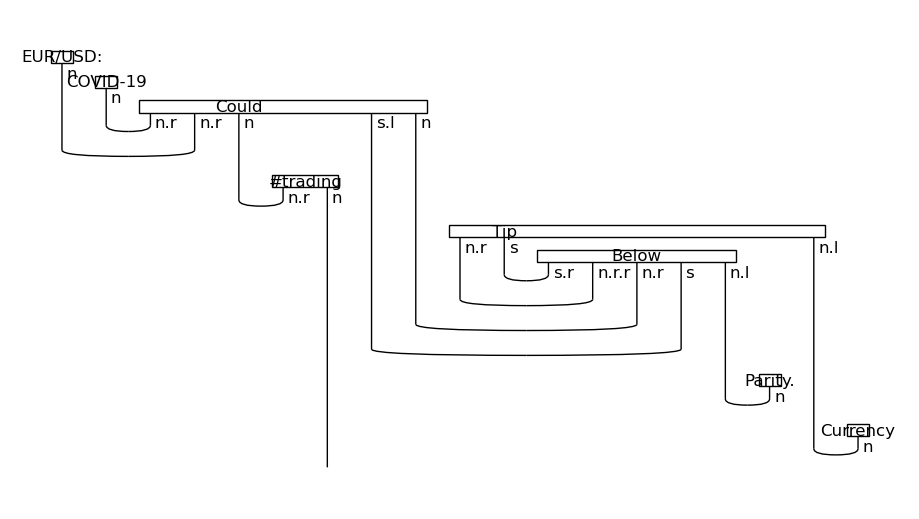

In [ ]:
### Test Step 2:
train_diagrams[52].draw(figsize=(9, 5), fontsize=12)


In [ ]:
### Step 2.1: Clean circuits
from lambeq import AtomicType, IQPAnsatz, remove_cups
N = AtomicType.NOUN
NP = AtomicType.NOUN_PHRASE
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE
PUNC = AtomicType.PUNCTUATION
C = AtomicType.CONJUNCTION

ansatz = IQPAnsatz({N: 1, S:0, NP: 0, PUNC:1, C: 1, P:1},
                   n_layers=3, n_single_qubit_params=2)

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

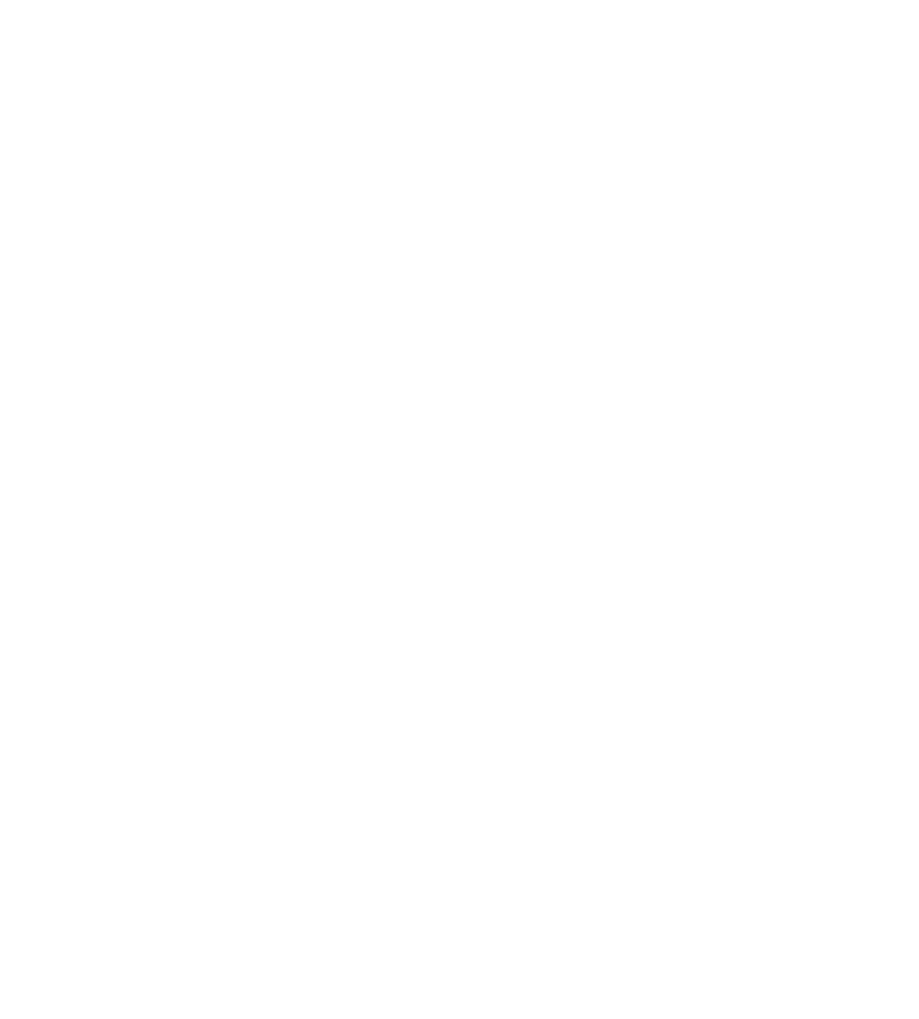

In [ ]:
### Test Step 2.1
train_circuits[6].draw(figsize=(9, 10))

In [ ]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits + val_circuits
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config = backend_config)


In [ ]:
from lambeq import BinaryCrossEntropyLoss
bce = BinaryCrossEntropyLoss()

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) /2
eval_metrics = {"acc": acc}


In [ ]:
from lambeq import QuantumTrainer, SPSAOptimizer

BATCH_SIZE = 5
EPOCHS = 10
SEED = 2

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

from lambeq import Dataset

train_dataset = Dataset(
    train_circuits,
    train_labels,
    batch_size = 20
)

val_dataset = Dataset(val_circuits, val_labels, batch_size = 20, shuffle = False)


In [65]:
trainer.fit(train_dataset, val_dataset, evaluation_step = 1, logging_step = 100)

AxisError: axis 1 is out of bounds for array of dimension 1